In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive/repositories/covid19_synthesis/

/content/drive/My Drive/repositories/covid19_synthesis


In [ ]:
from nbdev_c19_synthesis.c19_synthesis.core import *
from nbdev_c19_synthesis.c19_synthesis.cellular_automata import *

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import binary_erosion, binary_dilation
from scipy import ndimage
import os

In [ ]:
from sklearn.cluster import DBSCAN
from copy import copy
from scipy.ndimage import binary_closing
from scipy.ndimage import distance_transform_bf

In [ ]:
import torch
import torch.nn.functional as F
from time import time
from IPython.display import Image, HTML, clear_output

In [ ]:
import imageio
import os
import moviepy.editor as mvp
from pathlib import Path
from tqdm.notebook import tqdm

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3170304/45929032 bytes (6.9%)7077888/45929032 bytes (15.4%)11165696/45929032 bytes (24.3%)15106048/45929032 bytes (32.9%)18907136/45929032 bytes (41.2%)22921216/45929032 bytes (49.9%)26828800/45929032 bytes (58.4%)30646272/45929032 bytes (66.7%)34594816/45929032 bytes (75.3%)38633472/45929032 bytes (84.1%)42508288/45929032 bytes (92.6%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
%load_ext autoreload
%autoreload 2

# Project name here

> Summary description here.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## get lungs and cluster lesions

Fill me in please! Don't forget code examples:

In [ ]:
# read files
filename = 'covid19-A-0003_ct.nii.gz'
path_source = '/content/drive/My Drive/Datasets/covid19/COVID-19-20_v2/'
path_dest = '/content/drive/My Drive/KCL/covid19/inpainting_results/'
# load ct, normalize, rotate, 
ct, ct_mask, ct_seg = read_covid_CT_and_mask(path_source, filename)
ct, ct_mask, ct_seg = normalize_rotate(ct, ct_mask, ct_seg)
ct_small, ct_mask_small, ct_seg_small = ct, ct_mask, ct_seg
labelled, nr = label(ct_seg_small>0)
largest_component = (labelled == (np.bincount(labelled.flat)[1:].argmax() + 1))
# find the two lungs
ERODE_ITER = 5
ct_seg_erod = binary_erosion(ct_seg_small>0, iterations=ERODE_ITER)
lab, nr = label(ct_seg_erod)
lab_areas = np.array(ndimage.sum(ct_seg_erod, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 500000
two_lungs = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
two_lungs, nr = label(two_lungs)
assert nr == 2
# masks
bkgd = ct_seg_small == 0
target_mask = np.logical_or(bkgd,ct_mask_small)
target_mask = ~target_mask #lungs without lesions
target_mask2 = ~bkgd # lungs with lesions
target_mask3 = ct_mask_small.astype(bool) #lesions only
SLICE=100
# get largest lesion using label
lab, nr_ = label(target_mask3)
lab_areas = np.array(ndimage.sum(target_mask3, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 5000
one_big_lesion = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
lab, nr_ = label(one_big_lesion)
# get dimensions of one_big_lesion and find one_big_lesion is in left or right lung 
y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion = get_min_max(one_big_lesion)
for i in [1,2]:
  y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(two_lungs, LABEL=i)
  if y_min_lesion >= y_min and y_max_lesion <= y_max and x_min_lesion >= x_min and x_max_lesion <= x_max and z_min_lesion >= z_min and z_max_lesion <= z_max:
    coords_lung_inpaint = y_min, y_max, x_min, x_max, z_min, z_max
lung_inpaint = ct_seg_small[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
lung_one_big_lesion = one_big_lesion[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
# pad each dimension to length multiple of 32 (needed for inpainting, maye not anymore)
mask_inpain = ~(lung_one_big_lesion + (lung_inpaint==0))
img = pad_two_size_multiple_32(lung_inpaint)
mask_inpain = pad_two_size_multiple_32(mask_inpain)
lung_one_lesion = pad_two_size_multiple_32(lung_inpaint, lung_one_big_lesion)
# get the lung with the lesion
target_img_covid = img * lung_one_lesion
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(lung_one_lesion)
target_img_covid = target_img_covid[y_min: y_max, x_min: x_max, z_min: z_max]
SLICE = 50
im = copy(target_img_covid[...,SLICE])

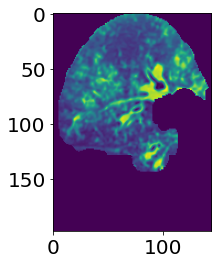

In [ ]:
plt.imshow(im)

## superpixels

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

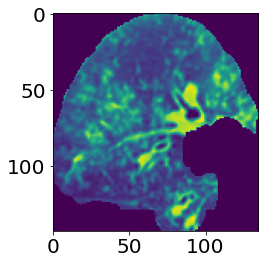

In [ ]:
# get the lung with the lesion
target_img_covid = img * lung_one_lesion
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(lung_one_lesion)
target_img_covid = target_img_covid[y_min: y_max, x_min: x_max, z_min: z_max]
SLICE = 50
im = copy(target_img_covid[...,SLICE])
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(np.expand_dims(im,-1)>0)
im2 = im[y_min: y_max, x_min: x_max]
plt.imshow(im2)

(-0.5, 134.5, 142.5, -0.5)

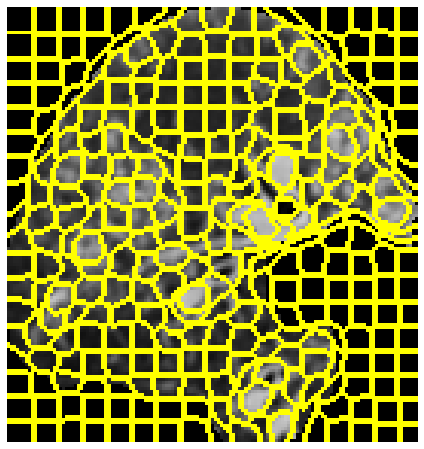

In [ ]:
numSegments = 300
plt.rcParams["lines.linewidth"] = .01
segments = slic(im2, n_segments = numSegments, sigma = 3, multichannel=False, compactness=.1)
# show the output of SLIC
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(im2, segments))
plt.axis("off")

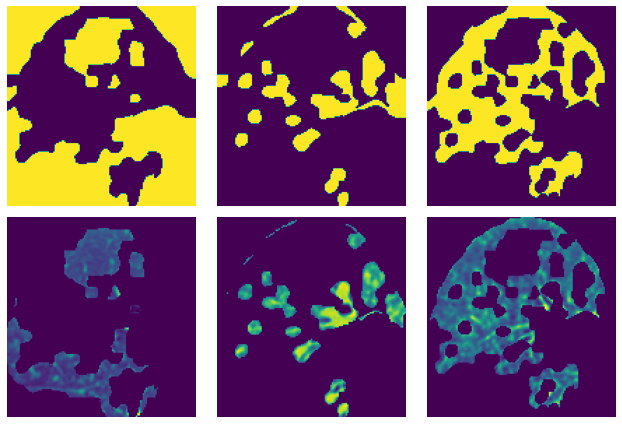

In [ ]:
import math
k=5
background = np.zeros_like(im2)
vessels = np.zeros_like(im2)
lesion_area = np.zeros_like(im2)
for (i, segVal) in tqdm(enumerate(np.unique(segments))):
  # if i < k:continue
  # if i == k+10: break
  mask = np.zeros_like(im2)
  mask[segments == segVal] = 1
  clus = im2*mask
  median_intensity = np.median(clus[clus>0])
  yy,xx = np.where(mask==1)
  if median_intensity < .2 or math.isnan(median_intensity):
    background[yy,xx]=1
  elif median_intensity>.4:
    vessels[yy,xx]=1
  else:
    lesion_area[yy,xx]=1

fig, ax = plt.subplots(2,3, figsize=(9,6))
ax[0,0].imshow(background)
ax[0,1].imshow(vessels)
ax[0,2].imshow(lesion_area)
ax[1,0].imshow(background*im2)
ax[1,1].imshow(vessels*im2)
ax[1,2].imshow(lesion_area*im2)
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

## cluster lesions


In [ ]:
#@title clustering one slice {vertical-output: true}
# segment with intensity thresholding
im = copy(target_img_covid[...,SLICE])
im_r = im.reshape(im.shape[0]*im.shape[1])
for i in range(im_r.shape[0]):
    im_r[i] = np.floor(im_r[i]*5)
im2 = im_r.reshape(im.shape[0],im.shape[1])

# clustering
mask_lesion2 = im2==2
mask_lesion1 = im2==1
mask_lesion = mask_lesion1 + mask_lesion2
small_lesions, labels  = apply_dbscan_to_mask(mask_lesion, skip_low_intensity=2)
# select_lesions_match_conditions and make or add to the targets and seeds lists
tgt_small, tgt_coords_small, tgt_masks_small, tgt_big, tgt_coords_big, tgt_masks_big =  select_lesions_match_conditions(small_lesions, target_img_covid, max_size=1000)
targets, coords, masks, seeds = make_list_of_targets_and_seeds(tgt_small, tgt_coords_small, tgt_masks_small)
print(f'lesions = {len(tgt_small)}, big lesions = {len(tgt_big)}')
# select lesions and add to lists from smaller lesions
smaller_merged_all = []
for idx_, (mask_small, coords_big_) in enumerate(zip(tgt_masks_big, tgt_coords_big)):
  # if idx_ >=1:break
  # grid search DBSCAN
  eps_sel, samp_sel = grid_search_DBSCAN_params(mask_small)
  smaller_lesions, labels = apply_dbscan_to_mask(mask_small, eps=eps_sel, min_samples=samp_sel)
  # use label to get not clustered areas 
  skip_low_intensity = 2
  last_idx = np.max(np.unique(labels))+skip_low_intensity
  smaller_multi = label_mask_and_add_to_clusters(smaller_lesions, last_idx)
  # merge labeled clusters
  smaller_merged = merge_labeled_clusters(smaller_multi, DIST=40)
  smaller_merged_orig_size = np.zeros_like(im)
  smaller_merged_orig_size[coords_big_[0]:coords_big_[1],coords_big_[2]:coords_big_[3]] = smaller_merged
  # select_lesions_match_conditions
  tgt_small2, tgt_coords_small2, tgt_masks_small2, tgt_big2, tgt_coords_big2, tgt_masks_big2 =  select_lesions_match_conditions(smaller_merged_orig_size, target_img_covid, max_size=1000)
  # make or add to the lists of targets and seeds
  targets, coords, masks, seeds = make_list_of_targets_and_seeds(tgt_small2, tgt_coords_small2, tgt_masks_small2, init_lists=False, targets=targets, seeds=seeds, masks=masks, coords=coords)
  print(f'total lesions = {len(targets)}')
  smaller_merged_all.append(smaller_merged)

lesions = 7, big lesions = 2



total lesions = 10



total lesions = 16


(18, 14, 2)


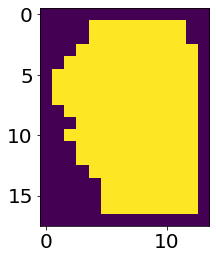

In [ ]:
print(np.shape(targets[5]))
plt.imshow(targets[5][...,1])

(17, 13, 2)


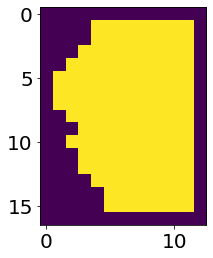

In [ ]:
print(np.shape(targets[5]))
plt.imshow(targets[5][...,1])

## cellular automata

In [ ]:
device = 'cuda'
num_channels = 16
epochs = 2500
sample_size = 8
IDX=0
target, coord, mask, this_seed = targets[IDX], coords[IDX], masks[IDX], seeds[IDX]

In [ ]:
from nbdev_c19_synthesis.c19_synthesis.cellular_automata import *

In [ ]:
# prepare seed
height, width, _ = np.shape(target)
seed = np.zeros([1, height, width, num_channels], np.float32)
for i in range(num_channels-1):
  seed[:,..., i+1] = this_seed
# initialize model
model = ca_model_perception_clamp(device = device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500,2500], gamma=0.1) ## keep 1e-4 longer
model_str = correct_label_in_plot(model)
# Preparing the seed pool
target0 = target
pool_size = 1024
seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
target = torch.tensor(target0.transpose(-1,0,1)).unsqueeze(0).to(device)
seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
losses = []
# train automata
target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')
start = time()
alive_masks = []
mask_diffs = []
inner_iter2 = 0
for i in range(epochs):
  ##
  if i < 100:
    inner_iter = 100
  elif i % 200 == 0: 
    inner_iter2 = inner_iter2 + 10
    inner_iter = np.min([inner_iter2, 100])

  scheduler.step()
  batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
  seed_batch = seed_pool[batch_idx].to(device)
  seed_batch[:1] = seed_tensor.to(device)
  
  loss, out, alive_mask, mask_diff = model.train_step(
      target = target_batch, 
      target_loss_func = F.mse_loss, 
      iters = inner_iter,
      seed = seed_batch,
      current_epoch = i,
      masked_loss = False
      )
  
  mask_diffs.append(mask_diff)
  alive_masks.append(alive_mask)

  seed_pool[batch_idx] = out.detach().to(device)
  loss.backward() # calculate gradients
  model.normalize_grads() # normalize them
  optimizer.step() # update weights and biases 
  optimizer.zero_grad() # prevent accumulation of gradients
  losses.append(loss.item())
  #early-stopping
  if loss.item() < 1e-5: break

  if i % 50==0 or i  == epochs-1:
    model_str_final = plot_loss_and_lesion_synthesis(losses, optimizer, model_str, i, loss, sample_size, out)

stop = time()
time_total = f'{(stop-start)/60:.1f} mins'
print(time_total)
model_str_final = model_str_final + f'\nep={i}, {time_total}' # for reconstruction figure

#lesion synthesis
x = torch.tensor(seed).permute(0,-1,1,2).to(device)
outs = []
with torch.no_grad():
  for i,special_sequence in zip(range(256),[1,1,1,3]*64):
    # x = model(x,special_sequence,101)
    x, alive_mask_, mask_diff_ = model(x,i,101)
    # x = model(x,i,i)
    out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
    outs.append(out)

#save results    
outs_masked = []
for out_ in outs:
    out_masked = np.squeeze(out_) * target[0,1,...].detach().cpu().numpy()
    out_masked[out_masked==1]=0
    outs_masked.append(out_masked)
outs_int = np.asarray(outs_masked)
print(np.shape(outs_int))
outs_int = np.clip(outs_int, 0 ,1)
outs_int = (outs_int*255).astype('int16')
print(idx_lesion)

In [ ]:
np.shape(mask_diffs), 
fig, ax = plt.subplots(2,1)
ax[0].imshow(alive_masks[0][0,0,...])
ax[1].imshow(mask_diffs[0][0,0,...])

In [ ]:
for i in range(10):
  m_alive, m_diff = alive_masks[i], mask_diffs[i]
  fig, ax = plt.subplots(2,1)
  ax[0].imshow(m_alive[0,0,...])
  ax[1].imshow(m_diff[0,0,...])
  for axx in ax.ravel(): axx.axis('off')

In [ ]:
from nbdev_c19_synthesis.c19_synthesis.cellular_automata import *

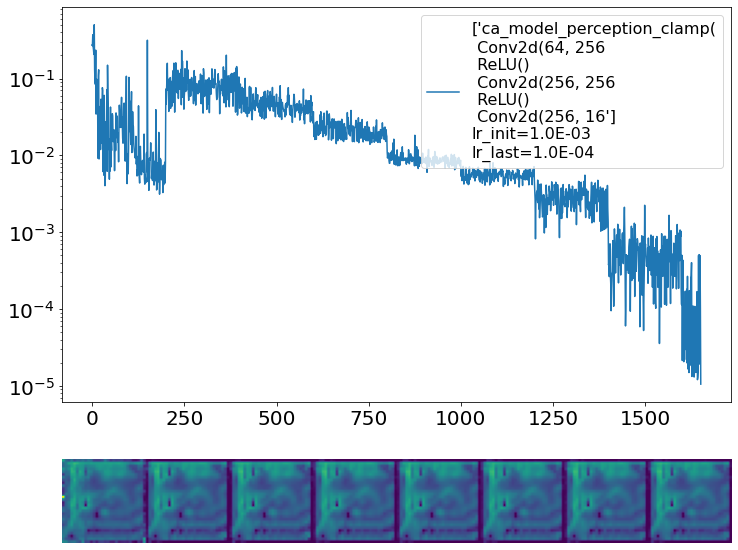

1650 1.054666154232109e-05
6.2 mins
(256, 30, 30)
15


In [ ]:
device = 'cuda'
num_channels = 16
epochs = 2500
sample_size = 8
for idx_lesion, (target, coord, mask, this_seed) in enumerate(zip(targets, coords, masks, seeds)):
  # if idx_lesion<12:continue
  # prepare seed
  height, width, _ = np.shape(target)
  seed = np.zeros([1, height, width, num_channels], np.float32)
  for i in range(num_channels-1):
    seed[:,..., i+1] = this_seed
  # initialize model
  model = ca_model_perception_clamp(device = device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500,2500], gamma=0.1) ## keep 1e-4 longer
  model_str = correct_label_in_plot(model)
  # Preparing the seed pool
  target0 = target
  pool_size = 1024
  seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
  target = torch.tensor(target0.transpose(-1,0,1)).unsqueeze(0).to(device)
  seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
  losses = []
  # train automata
  target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')
  start = time()
  alive_masks = []
  mask_diffs=[]
  inner_iter2 = 0
  for i in range(epochs):
    ##
    if i < 100:
      inner_iter = 100
    elif i % 200 == 0: 
      inner_iter2 = inner_iter2 + 10
      inner_iter = np.min([inner_iter2, 100])

    scheduler.step()
    batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
    seed_batch = seed_pool[batch_idx].to(device)
    seed_batch[:1] = seed_tensor.to(device)
    
    loss, out, alive_mask, mask_diff = model.train_step(
        target = target_batch, 
        target_loss_func = F.mse_loss, 
        iters = inner_iter,
        seed = seed_batch,
        current_epoch = i,
        masked_loss = False
        )
    
    alive_masks.append(alive_mask)
    mask_diffs.append(mask_diff)

    seed_pool[batch_idx] = out.detach().to(device)
    loss.backward() # calculate gradients
    model.normalize_grads() # normalize them
    optimizer.step() # update weights and biases 
    optimizer.zero_grad() # prevent accumulation of gradients
    losses.append(loss.item())
    #early-stopping
    if loss.item() < 1e-5: break

    if i % 50==0 or i  == epochs-1:
      model_str_final = plot_loss_and_lesion_synthesis(losses, optimizer, model_str, i, loss, sample_size, out)

  stop = time()
  time_total = f'{(stop-start)/60:.1f} mins'
  print(time_total)
  model_str_final = model_str_final + f'\nep={i}, {time_total}' # for reconstruction figure
  
  #lesion synthesis
  x = torch.tensor(seed).permute(0,-1,1,2).to(device)
  outs = []
  with torch.no_grad():
    for i,special_sequence in zip(range(256),[1,1,1,3]*64):
      # x = model(x,special_sequence,101)
      x, alive_mask_, mask_diff_ = model(x,i,101)
      # x = model(x,i,i)
      out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
      outs.append(out)
  
  #save results    
  outs_masked = []
  for out_ in outs:
      out_masked = np.squeeze(out_) * target[0,1,...].detach().cpu().numpy()
      out_masked[out_masked==1]=0
      outs_masked.append(out_masked)
  outs_int = np.asarray(outs_masked)
  print(np.shape(outs_int))
  outs_int = np.clip(outs_int, 0 ,1)
  outs_int = (outs_int*255).astype('int16')
  print(idx_lesion)
  path_save_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient04/'
  np.savez_compressed(f'{path_save_synthesis}lesion_{idx_lesion}.npz', outs_int)
  np.save(f'{path_save_synthesis}coords_lesion_{idx_lesion}.npy', coord)
  np.savez_compressed(f'{path_save_synthesis}mask_lesion_{idx_lesion}.npz', mask)
  np.save(f'{path_save_synthesis}loss_lesion_{idx_lesion}.npy', losses)
  np.save(f'{path_save_synthesis}total_time_lesion_{idx_lesion}_{time_total}.npy', time_total)

In [ ]:
for i in np.arange(1,16,1):
  print(i)

NameError: ignored